In [1]:
from astropy.io import fits 
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import style

In [2]:
parametri = [
    [{'sigma':0.02, 'h':25,'rho':1.0},
    {'sigma':0.02, 'h':50,'rho':1.0},
    {'sigma':0.02, 'h':75,'rho':1.0}],
    
    [{'sigma':0.02, 'h':50,'rho':1.0},
    {'sigma':0.01, 'h':50,'rho':1.0},
    {'sigma':0.005, 'h':50,'rho':1.0}],
    
    [{'sigma':0.02, 'h':5,'rho':1.0},
    {'sigma':0.01, 'h':5,'rho':1.0},
    {'sigma':0.005, 'h':5,'rho':1.0}]
    ]

N_mis = 10000
numerotest = 1

In [3]:
# calcolo covarianza da matrice in input
def Covariance(matrix,average = False):
    avg = matrix.mean(axis = 0)
    length_mat = len(matrix[0,:])
    vet = []
    
    for i in range(length_mat):
        vet.append(matrix[:,i]-avg[i])
    vet = np.array(vet)
    
    cov = np.matmul(vet,vet.T)
    
    if average:
        return avg, cov
    else:
        return np.array(cov)/(len(matrix[:,0])-1)

# lettura dati da directory e salvataggio in array    
def letturaDati(N_mis,test,keyword):
    
    misure = []
    for i in tqdm(np.arange(N_mis)+1,dynamic_ncols=True,desc='Reading: '):
        fname = f'MockMeasures_2PCF_Test{test}/MockMeasures_2PCF_Correlation_MULTIPOLES_Test{test}_{i}.fits'
        
        file = fits.open(fname)
        table = file[1].data.copy()
        misure.append(table[keyword])
        if (i==1):
            scale = table['SCALE']
        del table
        file.close()
    return np.array(misure), np.array(scale)

# calcolo correlazione da matrice in input
def Correlation(matrix):
    length_mat = matrix.shape
    diag = np.diag(matrix)
    cov = np.zeros(length_mat)
    for i in range(length_mat[0]):
        for j in range(length_mat[1]):
            cov[i,j]=matrix[i,j]/np.sqrt(diag[i]*diag[j])
    return cov


def Th_Covariance(distanze,multipoli, parametri):
    l_1 = multipoli[0]
    l_2 = multipoli[1]
    somma_h = parametri[l_1]['h']**2+parametri[l_2]['h']**2
    dim = len(distanze)
    cov = np.zeros((dim,dim))
    if (multipoli[0]==multipoli[1]):
        for i in range(dim):
            for j in range(dim):
                cov[i,j] = (parametri[l_1]['sigma']**2)*np.exp(-((distanze[i]-distanze[j])**2)/(2*parametri[l_1]['h']**2))
        return cov
    elif (multipoli[0] != multipoli[1]):
        for i in range(dim):
            for j in range(dim):
                cov[i,j] = (parametri[l_1]['sigma']*parametri[l_2]['sigma'])*np.sqrt((2*parametri[l_1]['h']*parametri[l_2]['h'])/(somma_h))*np.exp(-((distanze[i]-distanze[j])**2)/somma_h)
        return cov

def Res(th_covariance,covariance,N_mis,N_bins = 200):
    TH_CORR = Correlation(th_covariance)
    RES = np.zeros((N_bins,N_bins))
    diag = np.diag(th_covariance)
    for i in range(N_bins):
        for j in range(N_bins):
            RES[i,j] = (th_covariance[i,j] - covariance[i,j])*np.sqrt((N_mis-1)/((1+TH_CORR[i,j])*diag[i]*diag[j]))
    return RES


def plot_figure(array_matrix, cmap = 'viridis',size = (7,5),title = ''):
    fig = plt.figure(figsize=size)
    ax = fig.add_subplot(111)
    ax.set_title(title)
    plt.imshow(array_matrix,cmap=cmap)
    ax.set_aspect('equal')

    cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
    cax.get_xaxis().set_visible(False)
    cax.get_yaxis().set_visible(False)
    cax.set_frame_on(False)
    plt.colorbar(orientation='vertical',ax = ax)
    plt.style.use('ggplot') # cambio stile plot
    plt.show()
        
    return

def plot_figures(array_matrix1,array_matrix2, cmap = 'viridis',size = (7,5),title_1 = '',title_2 = ''):
    fig = plt.figure(figsize=size)
    gs = fig.add_gridspec(1,2, wspace = 0.1)
    axs = gs.subplots(sharey=True)
    map1 = axs[0].imshow(array_matrix1,cmap = cmap)
    map2 = axs[1].imshow(array_matrix2,cmap = cmap)

    axs[0].set_title(title_1, fontsize = 20)
    axs[1].set_title(title_2, fontsize = 20)
    axs[0].set_xlabel('N Bins',fontsize = 16)
    axs[1].set_xlabel('N Bins',fontsize = 16)
    axs[0].set_ylabel('N Bins',fontsize = 16)
    cbar1 = plt.colorbar(map1,orientation = 'horizontal',ax=axs[1])
    cbar2 = plt.colorbar(map2,orientation = 'horizontal',ax=axs[0])
    
    cbar1.ax.tick_params(labelsize = 12)
    cbar2.ax.tick_params(labelsize = 12)
    return


# calcolo la cross-covarianza della matrice in input
def Cross_covariance(matrix):
    D = [[],[],[]]
    cov = []
    for j in range(len(matrix)):
        avg = matrix[j].mean(axis = 0)
        dim_matrix = len(matrix[j][0,:])
        
        for i in range(dim_matrix):
            D[j].append(matrix[j][:,i]-avg[i])
        D[j] = np.array(D[j])
        del avg
    for k in range(3):
        for l in range(3):
            cov.append(np.matmul(D[k],D[l].T)/(len(matrix[0][:,0])-1))
    
    return np.array(cov)

def block_matrix(matrix):
    m2 = np.concatenate(matrix[0:3])
    m3 = np.concatenate(matrix[3:6])
    m4 = np.concatenate(matrix[6:9])
    
    return np.concatenate((m2,m3,m4),axis=1)

def Res_cross(th_matrix,matrix,N_mis,N_bins = 200):
    res = []
    for k in range(9):
        res.append(Res(th_matrix[k],matrix[k],N_mis))
        
    return np.array(res)

def Th_Cross_Covariance(matrix,parametri):
    theoretical_cross_correlation = []
    for i in range(3):
        for j in range(3):
            theoretical_cross_correlation.append(Th_Covariance(matrix[i],[i,j],parametri))
        
    return np.array(theoretical_cross_correlation)

In [4]:
misure,distanze = letturaDati(N_mis = N_mis,test = numerotest,keyword = 'XI0')

Reading: 100%|████████████████████████████| 10000/10000 [02:43<00:00, 61.19it/s]


Hai passato il controllo! La differenza massima è: 5.421010862427522e-20


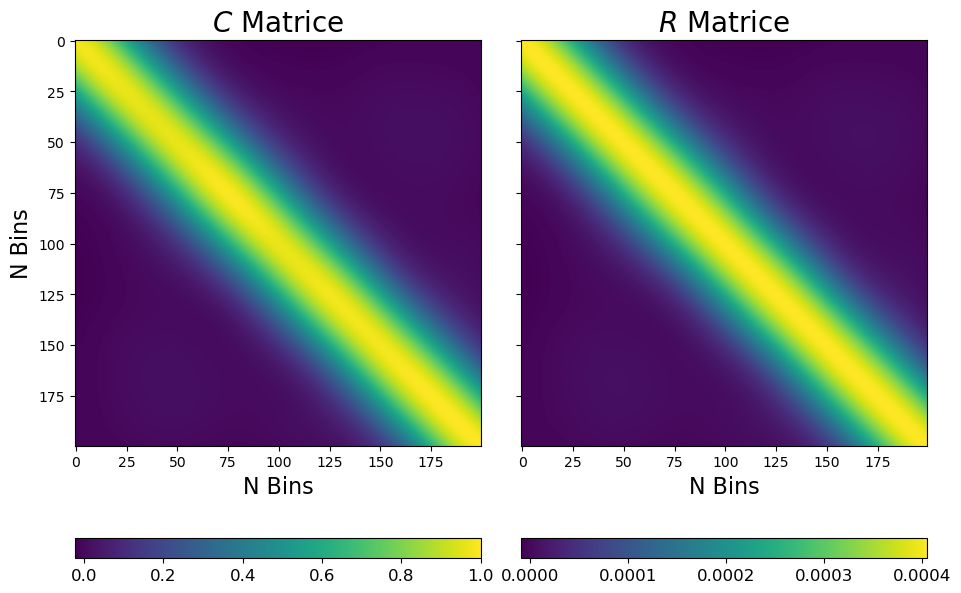

In [5]:
cov = np.cov(misure.T)
cooov = Covariance(misure)
corr = Correlation(cov)


epsilon = 1e-15
diff = np.max(np.abs(cov-cooov))
if diff < epsilon:
    print(f'Hai passato il controllo! La differenza massima è: {diff}')
else:
    print(f'ATTENZIONE! La differenza massima è: {diff} > {epsilon}')

plot_figures(cov,corr,title_1 = '$C$ Matrice',title_2='$R$ Matrice',size = (11,8))

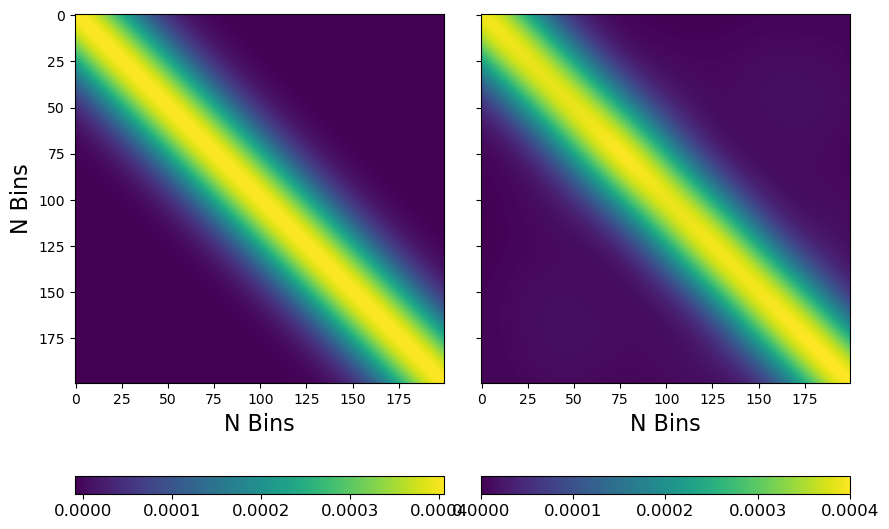

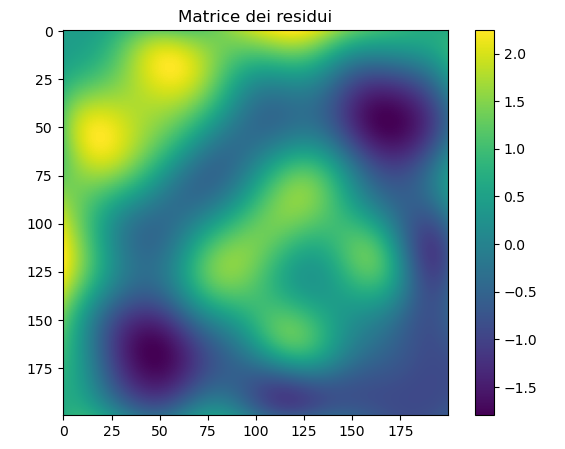

Deviazione Standard: 0.9471380341783253


In [6]:
covth = Th_Covariance(distanze,[0,0],parametri[0])
res = Res(covth,cov,N_mis)
plot_figures(covth,cov,size = (10,8))

plot_figure(res,title = 'Matrice dei residui')
print(f'Deviazione Standard: {np.std(res.reshape(200*200))}')

In [8]:
keyword_list = ['XI0','XI2','XI4']
distanzedati = []
misuredati = []
for dipoles in keyword_list:
    print(f'Sto leggendo i dipopli {dipoles}...')
    temp0,temp1 = letturaDati(N_mis = N_mis,test = numerotest,keyword = dipoles)
    distanzedati.append(temp1)
    misuredati.append(temp0)
    del temp0
    del temp1

Sto leggendo i dipopli XI0...


Reading: 100%|████████████████████████████| 10000/10000 [02:36<00:00, 63.79it/s]


Sto leggendo i dipopli XI2...


Reading: 100%|████████████████████████████| 10000/10000 [02:47<00:00, 59.83it/s]


Sto leggendo i dipopli XI4...


Reading: 100%|████████████████████████████| 10000/10000 [02:31<00:00, 65.94it/s]


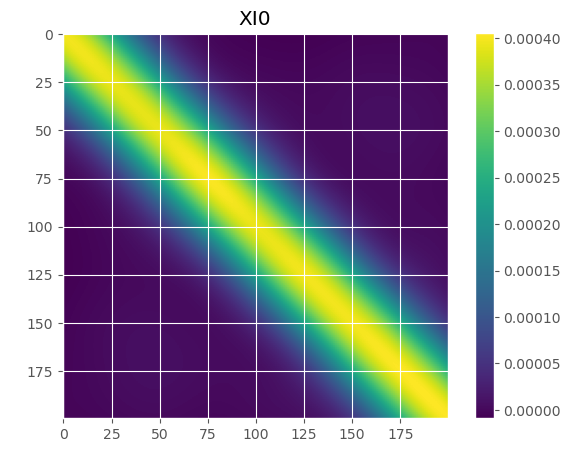

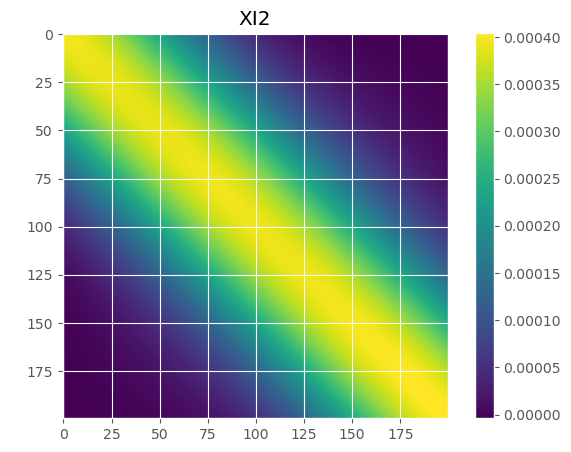

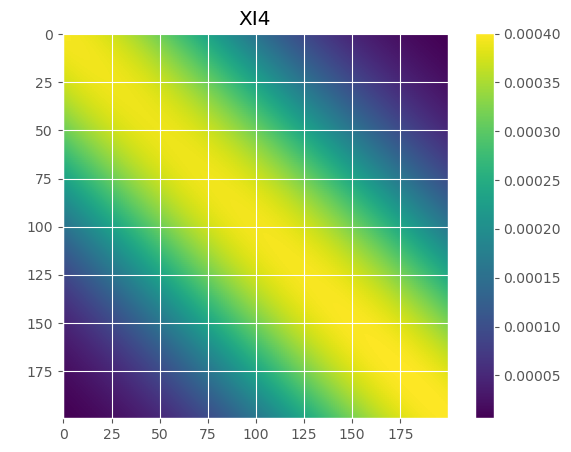

In [9]:
cov = []
cor = []
for i in range(len(misuredati)):
    cov.append(Covariance(misuredati[i]))
    cor.append(Correlation(cov[i]))

for i in range(len(misuredati)):
    plot_figure(cov[i],title=keyword_list[i])  

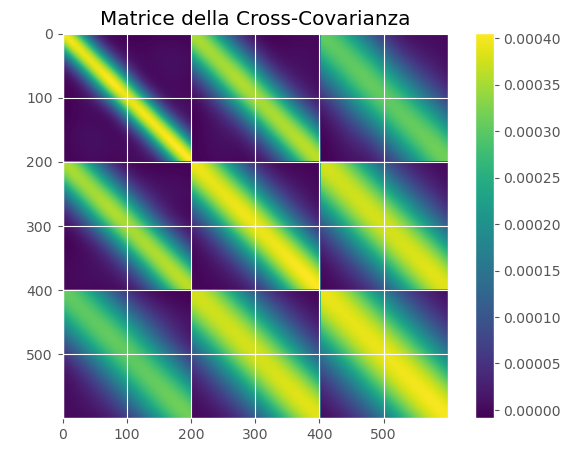

In [10]:
covtot = Cross_covariance(misuredati)
block = block_matrix(covtot)
plot_figure(block,title='Matrice della Cross-Covarianza')

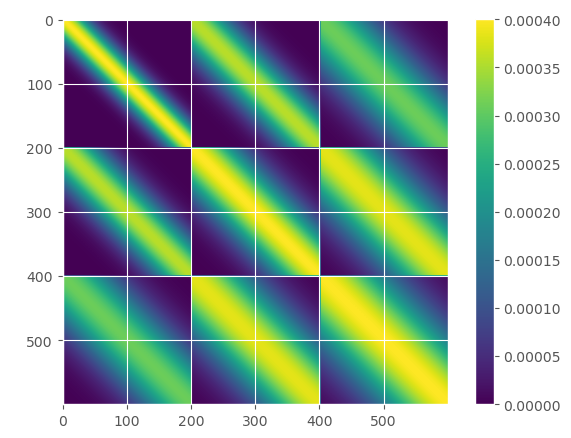

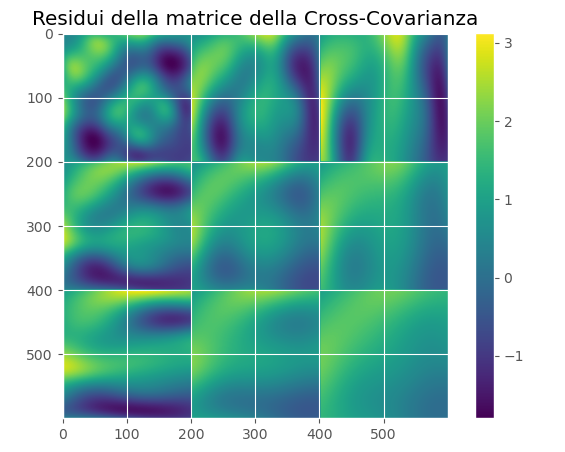

Deviazione Standard: 0.9114166373941788


In [12]:
teeest = numerotest-1
crosscov = Th_Cross_Covariance(distanzedati,parametri[teeest])
blockcross = block_matrix(crosscov)
plot_figure(blockcross)
res = Res_cross(crosscov,covtot,N_mis)
plot_figure(block_matrix(res),title='Residui della matrice della Cross-Covarianza')
print(f'Deviazione Standard: {np.std(res.reshape(600*600))}')